# Query language models
Let's test different monolingual models for the task of filling in blanks for relationship targets.

We'll use the multilingual BERT model for consistency across languages. If this gives weird results for specific languages (e.g. poor accuracy only for Italian), we may pivot to using individual models for each language.

In [1]:
## TODO: https://huggingface.co/bert-base-multilingual-cased
from transformers import BertTokenizer, BertModel, pipeline
cache_dir = 'data/'
# tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', cache_dir=cache_dir)
model_pipeline = pipeline('fill-mask', model='bert-base-multilingual-cased', tokenizer='bert-base-multilingual-cased', model_kwargs={'cache_dir' : cache_dir})

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
a = model_pipeline.tokenizer('el hombre se casó con su novio')
print(model_pipeline.tokenizer.convert_ids_to_tokens(a['input_ids']))

['[CLS]', 'el', 'hombre', 'se', 'casó', 'con', 'su', 'novi', '##o', '[SEP]']


In [63]:
import pandas as pd
# import torch
# def pred_mask_tokens(sent, tokenizer, model):
#     model_input = tokenizer(sent)
#     model_output = model(model_input)
#     logits = model_output.logits
#     token_map = 
test_sents = [
    'The man married his [MASK].', 
    'El hombre se casó con su [MASK].',
    "L'homme s'est marié avec son [MASK].",
    "L'homme s'est marié avec sa [MASK]."
]
test_targets = [
    ['wife', 'husband', 'girlfriend', 'boyfriend'],
    ['esposa', 'esposo', 'novia', 'novio'],
    ['épouse', 'époux', 'copain'],
    ['copine'],
]
for test_sent_i, test_targets_i in zip(test_sents, test_targets):
    test_sent_pred_i = model_pipeline(test_sent_i, targets=test_targets_i)
    test_sent_pred_i = pd.DataFrame(test_sent_pred_i)
    display(test_sent_pred_i)

,sequence,score,token,token_str
0,The man married his wife.,0.034301,14384,wife
1,The man married his husband.,0.002665,19634,husband
2,The man married his girlfriend.,0.000097,77877,girlfriend
3,The man married his boyfriend.,0.000029,109465,boyfriend


The specified target token `novio` does not exist in the model vocabulary. Replacing with `novi`.


,sequence,score,token,token_str
0,El hombre se casó con su esposa.,0.123317,19217,esposa
1,El hombre se casó con su esposo.,0.009511,98473,esposo
2,El hombre se casó con su novia.,0.002240,110845,novia
3,El hombre se casó con su novi.,0.000119,39122,novi


The specified target token `copain` does not exist in the model vocabulary. Replacing with `copa`.


,sequence,score,token,token_str
0,L'homme s'est marié avec son épouse.,0.031738,23791,épouse
1,L'homme s'est marié avec son époux.,0.003428,102182,époux
2,L'homme s'est marié avec son copa.,0.000004,39313,copa


The specified target token `copine` does not exist in the model vocabulary. Replacing with `cop`.


,sequence,score,token,token_str
0,L'homme s'est marié avec sa cop.,0.000014,35691,cop


OK! As expected, same-gender relationships are way less predictable than different-gender relationships.

We're getting some major OOV errors that are only going to get worse as we get into more niche occupation words.

We're going to have to switch to computing PPL rather than P(individual words) to handle these weird tokenization problems.

In [129]:
import torch
test_sents = [
    'The man married his wife.', 
    'The man married his husband.',
    'The man married his girlfriend.', 
    'The man married his boyfriend.', 
]
for sent_i in test_sents:
    tokens_i = model_pipeline.tokenizer(sent_i, return_tensors='pt')
    raw_tokens_i = model_pipeline.tokenizer(sent_i, add_special_tokens=False)
    with torch.no_grad():
        sent_output_i = model_pipeline.model(tokens_i['input_ids'], labels=tokens_i['input_ids'])
#     logit_i = sent_output_i.logits
    # convert to log-probability per-token => log-softmax!
#     logit_i = torch.log(torch.softmax(logit_i, dim=2))
#     prob_i = logit_i[:, list(range(len(raw_tokens_i['input_ids']))), raw_tokens_i['input_ids']].sum()
    ppl_i = torch.exp(sent_output_i.loss)
    print(f'sent = {sent_i}; score={ppl_i:.3f}')

sent = The man married his wife.; score=31.150
sent = The man married his husband.; score=31.001
sent = The man married his girlfriend.; score=31.702
sent = The man married his boyfriend.; score=30.705


In [9]:
test_sents = [
    'El abogado se casó con su esposa.',
    'El abogado se casó con su esposo.',
    'El abogado se casó con su novia.',
    'El abogado se casó con su novio.',
]
for sent_i in test_sents:
    tokens_i = model_pipeline.tokenizer(sent_i, return_tensors='pt')
    raw_tokens_i = model_pipeline.tokenizer(sent_i, add_special_tokens=False)
    with torch.no_grad():
        sent_output_i = model_pipeline.model(tokens_i['input_ids'], labels=tokens_i['input_ids'])
    logit_i = sent_output_i.logits
    # convert to log-probability per-token => log-softmax!
    logit_i = torch.log(torch.softmax(logit_i, dim=2))
    prob_i = logit_i[:, list(range(len(raw_tokens_i['input_ids']))), raw_tokens_i['input_ids']].sum()
    ppl_i = torch.exp(sent_output_i.loss)
    print(f'sent = {sent_i}; score={prob_i:.3f}')

sent = El abogado se casó con su esposa.; score=-106.996
sent = El abogado se casó con su esposo.; score=-107.592
sent = El abogado se casó con su novia.; score=-109.371
sent = El abogado se casó con su novio.; score=-138.591


OK! The scores are indeed slightly different.

Let's run the predictions for the same sample sentences that we've generated before. 

ASSUMPTION: the wonky sub-word vocabulary in BERT will affect the different-gender relationships in the same way as the same-gender relationships. This should hold?

In [79]:
display(relationship_words.head())
genders = ['female', 'male']
flat_relationship_words = []
for gender_i in genders:
    relationship_words_i = pd.melt(relationship_words, id_vars=[f'en_{gender_i}'], value_vars=[f'{lang}_{gender_i}' for x in langs], value_name='lang', var_name='')
    
display()

# relationship_words.pivot(columns=['en_female', 'en_male'], values=['fr_female', 'fr_male', 'es_female', 'es_male', 'it_female', 'it_male'])

,en_female,en_male,fr_female,fr_male,es_female,es_male,it_female,it_male
0,girlfriend,boyfriend,petite amie,petit ami,novia,novio,ragazza,ragazzo
1,fiancée,fiancé,fiancée,fiancé,prometida,prometido,fidanzata,fidanzato
2,wife,husband,épouse,époux,esposa,esposo,moglie,marito


,en_female,variable,value
0,girlfriend,fr_female,petite amie
1,fiancée,fr_female,fiancée
2,wife,fr_female,épouse
3,girlfriend,es_female,novia
4,fiancée,es_female,prometida
5,wife,es_female,esposa
6,girlfriend,it_female,ragazza
7,fiancée,it_female,fidanzata
8,wife,it_female,moglie


In [21]:
## load previously generated sentences
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import load_relationship_occupation_template_data, generate_occupation_relationship_sentence_data, translate_subject_relationship_words
occupation_words, relationship_words, relationship_sents, langs, lang_art_PRON_lookup, lang_POSS_PRON_lookup = load_relationship_occupation_template_data()
langs = ['es', 'fr', 'it']
## TODO: generate sents for EN data => need custom generation procedure 
## because ENG possessive pronouns don't get gender from target but from subject
## TODO: add column for relationship verb
same_gender_relationship_sent_data = generate_occupation_relationship_sentence_data(relationship_sents, 
                                                                                    occupation_words, 
                                                                                    relationship_words,
                                                                                    lang_art_PRON_lookup, 
                                                                                    lang_POSS_PRON_lookup,
                                                                                    relationship_type='same_gender', 
                                                                                    langs=langs)
diff_gender_relationship_sent_data = generate_occupation_relationship_sentence_data(relationship_sents, 
                                                                                    occupation_words, 
                                                                                    relationship_words,
                                                                                    lang_art_PRON_lookup, 
                                                                                    lang_POSS_PRON_lookup,
                                                                                    relationship_type='diff_gender', 
                                                                                    langs=langs)
import pandas as pd
relationship_sent_data = pd.concat([
    same_gender_relationship_sent_data.assign(**{'relationship_type' : 'same_gender'}),
    diff_gender_relationship_sent_data.assign(**{'relationship_type' : 'diff_gender'}),
], axis=0)
## add EN translations + relationship-target categories
from data_helpers import translate_subject_relationship_words
relationship_sent_data = translate_subject_relationship_words(relationship_sent_data, occupation_words, relationship_words)



In [88]:
relationship_target_categories = {
    'FRIEND' : ['boyfriend', 'girlfriend'],
    'ENGAGE' : ['fiance', 'fiancee'],
    'SPOUSE' : ['husband', 'wife'],
}
relationship_target_categories = {
    v1 : k for k, v in relationship_target_categories.items() for v1 in v
}
relationship_sent_data = relationship_sent_data.assign(**{
    'relationship_word_category' : relationship_sent_data.loc[:, 'relationship_word_en'].apply(relationship_target_categories.get)
})

Compute probability for ALL the data!!

In [53]:
def compute_prob(sent, model_pipeline):
    tokens = model_pipeline.tokenizer(sent, return_tensors='pt')
    raw_tokens = model_pipeline.tokenizer(sent, add_special_tokens=False)
    with torch.no_grad():
        sent_output = model_pipeline.model(tokens['input_ids'], labels=tokens['input_ids'])
    logit = sent_output.logits
#     print(f'{len(raw_tokens["input_ids"])} raw tokens')
#     print(f'logit shape = {logit.shape}')
    # convert to log-probability per-token  => log-softmax!
    logit = torch.log(torch.softmax(logit, dim=2))
    prob = logit[:, list(range(len(raw_tokens['input_ids']))), raw_tokens['input_ids']].sum()
    prob = float(prob)
    ppl = float(torch.exp(sent_output.loss))
    return prob, ppl

In [51]:
from tqdm import tqdm
tqdm.pandas()
relationship_sent_data = relationship_sent_data.assign(**{
    'prob_ppl' : relationship_sent_data.loc[:, 'sent'].progress_apply(lambda x: compute_prob(x, model_pipeline))
})
## separate prob, ppl
relationship_sent_data = relationship_sent_data.assign(**{
    'prob' : relationship_sent_data.loc[:, 'prob_ppl'].apply(lambda x: x[0]),
    'ppl' : relationship_sent_data.loc[:, 'prob_ppl'].apply(lambda x: x[1]),
}).drop(['prob_ppl'], axis=1)
## save!
relationship_sent_data.to_csv('../../data/multilingual_occupation_relationship_LM_probs.gz', sep='\t', compression='gzip')

100%|██████████| 5640/5640 [05:15<00:00, 17.85it/s]


Let's look at the overall probability difference.

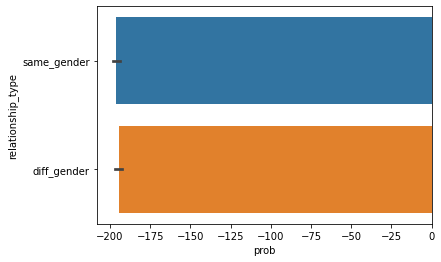

stat = prob; mean diff = -1.638 (test stat = -7.663; p = 2.486E-14)


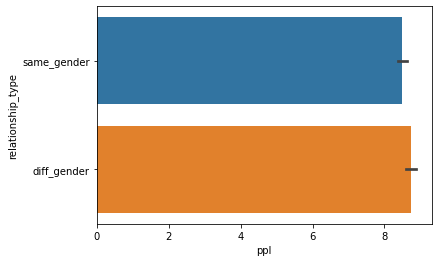

stat = ppl; mean diff = -0.229 (test stat = -8.337; p = 1.173E-16)


In [64]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
prob_stats = ['prob', 'ppl']
for prob_stat_i in prob_stats:
    sns.barplot(data=relationship_sent_data, y='relationship_type', x=prob_stat_i)
    plt.show()
    ## significance testing
    from scipy.stats import ttest_rel
    aligned_same_gender_data = relationship_sent_data[relationship_sent_data.loc[:, 'relationship_type']=='same_gender'].sort_values(['lang', 'subject_word', 'relationship_word', 'subject_gender'])
    aligned_diff_gender_data = relationship_sent_data[relationship_sent_data.loc[:, 'relationship_type']=='diff_gender'].sort_values(['lang', 'subject_word', 'relationship_word', 'subject_gender'])
    same_gender_probs = aligned_same_gender_data.loc[:, prob_stat_i]
    diff_gender_probs = aligned_diff_gender_data.loc[:, prob_stat_i]
    mean_diff = (same_gender_probs - diff_gender_probs).mean()
    test_stat, p_val = ttest_rel(same_gender_probs, diff_gender_probs)
    print(f'stat = {prob_stat_i}; mean diff = {mean_diff:.3f} (test stat = {test_stat:.3f}; p = {p_val:.3E})')

Great! The differences are significant. It seems like PPL is doing something weird because it shouldn't be higher for `diff_gender`.

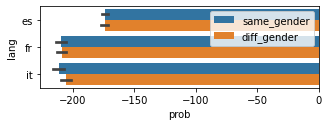

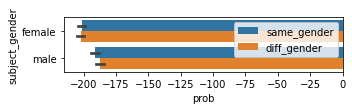

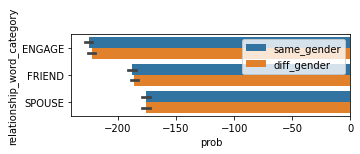

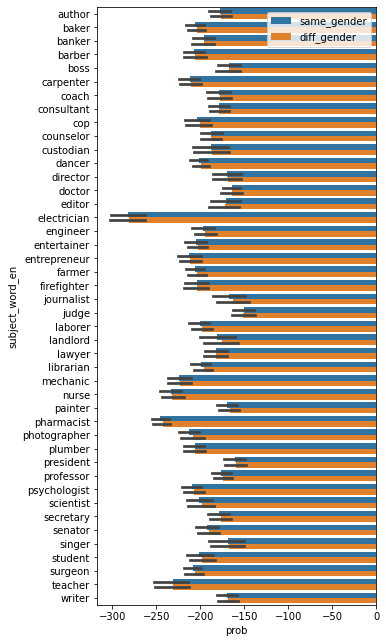

In [98]:
## breakdown by language, gender, target, relationship, source occupation
relationship_vars = ['lang', 'subject_gender', 'relationship_word_category', 'subject_word_en']
width = 5
height = 0.5
for var_i in relationship_vars:
    vals_i = relationship_sent_data.loc[:, var_i].nunique()
    height_i = vals_i*height
    if(vals_i > 10):
        height_i = height_i * 0.5
    plt.figure(figsize=(width, height_i))
    val_order_i = list(sorted(relationship_sent_data.loc[:, var_i].unique()))
    sns.barplot(data=relationship_sent_data, x='prob', y=var_i, order=val_order_i, hue='relationship_type')
    plt.legend(loc='upper right')
    plt.show()
    ## TODO: significance tests between  types

OK! We can see pretty clearly that same-gender relationships are dispreferred pretty much across the board.

Trends in same - diff difference:
- gender: `male` > `female`
- lang: `it` >>> `fr` ~ `es`
- target: `ENGAGE` > `FRIEND` ~ `SPOUSE`
- occupation: `author`, `dancer`, `engineer`,`landlord`, `nurse`, `painter`, `pharmacist`, `surgeon`, `student`

In [ ]:
## TODO: correlate (same gender - diff gender) prob differences with translation accuracy differences => is it more likely English LM or source LM that leads to translation errors??
